In [1]:
import numpy as np
import pandas as pd
import os
import pickle
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
from tape import ProteinBertModel, TAPETokenizer

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns

import sys
path = '../repos/embeddings_reproduction/'
sys.path.append(path+'/src/')
from embeddings_reproduction import embedding_tools

In [2]:
df = pd.read_csv('Data/reproducibility.csv')
df.head()

,peptide,peptide_aromaticity,peptide_gravy,peptide_helix,peptide_instability_index,peptide_isoelectric_point,peptide_len,peptide_log_len,peptide_log_weight,peptide_mean,...,protein_isoelectric_point,protein_len,protein_log_len,protein_log_weight,protein_molar_extinction_coefficient,protein_sheet,protein_turn,protein_weight,reproducibility,reproducibility_corrected
0,AAAATGTIFTFR,0.166667,0.858333,0.250000,5.300000,9.795020,12,2.484907,7.111823,20.783651,...,8.939847,356,5.874931,10.599246,25900.0,0.261236,0.233146,40104.5947,0.602647,0.131780
1,AAAIQTMSLDAER,0.000000,0.069231,0.153846,43.030769,4.370373,13,2.564949,7.227325,22.568058,...,6.411404,2124,7.661056,12.374699,336410.0,0.229755,0.266478,236735.5285,0.225532,-0.148407
2,AACAQLNDFLQEYGTQGCQV,0.100000,-0.115000,0.250000,33.830000,4.050028,20,2.995732,7.677565,23.491978,...,6.294657,1564,7.355002,12.056308,171207.5,0.273018,0.243606,172182.0885,0.344353,-0.159834
3,AADDTWEPFASGK,0.153846,-0.815385,0.153846,2.676923,4.050028,13,2.564949,7.240249,29.672498,...,5.233700,820,6.709304,11.417560,142140.0,0.245122,0.215854,90904.0680,0.288063,-0.022109
4,AADHDVGSELPPEGVLGALLR,0.000000,0.100000,0.285714,42.357143,4.308305,21,3.044522,7.657439,26.325119,...,5.150261,37,3.610918,8.346772,5500.0,0.432432,0.135135,4216.5498,0.396802,0.087727


In [20]:
def save_doc2vec_embeds(df):
    peptides = df['peptide'].values
    models = ((1, 1), (1, 3), (1, 5), (3, 1), (3, 3), (3, 5), (5, 7))
    for k, w in models:
        model_file = f'../repos/embeddings_reproduction/models/original_{k}_{w}.pkl'
        embeds = embedding_tools.get_embeddings(model_file, peptides, k=k, overlap=False)
        embeds_dict = {peptide:embed for peptide, embed in zip(peptides, embeds)}
        pickle.dump(embeds_dict, open(f'Data/Embeds/single_pass_from_model_{k}_{w}.pkl', 'wb'))

In [ ]:
def save_bert_embeds(df):
    model = ProteinBertModel.from_pretrained('bert-base')
    tokenizer = TAPETokenizer(vocab='iupac')  # iupac is the vocab for TAPE models, use unirep for the UniRep model

    embeds_dict = {}
    for peptide in df.peptide.values:
        token_ids = torch.tensor([tokenizer.encode(peptide)])
        with torch.no_grad():
            output = model(token_ids)
            embeds_dict[peptide] = output[1].squeeze(0).numpy()
    pickle.dump(embeds_dict, open('Data/Embeds/bert_embeds.pkl', 'wb'))

In [ ]:
# save_doc2vec_embeds(df)
# save_bert_embeds(df)

In [206]:
# 3_1 Best

# model = make_pipeline(StandardScaler(), KernelRidge(kernel='poly', degree=2, alpha=8))
# model =  KernelRidge(kernel='poly', degree=3, alpha=3)
model = KNeighborsRegressor(n_neighbors=100)
# model = LinearRegression()
df = pd.read_csv('Data/reproducibility.csv')
df = df.sample(frac=1).reset_index(drop=True)
y = df.reproducibility.values
groups = LabelEncoder().fit_transform(df.protein_id.values)

path = './Data/embeds/'
files = os.listdir(path)[1:] 
scores = []
errors = []
for file in files:
    embeds_map = pickle.load(open(path+file, 'rb'))
    embeds = df.peptide.map(embeds_map).values
    embeds = np.vstack(embeds)
    score = -cross_val_score(model, embeds, y, groups=groups,
                             cv=GroupKFold(), 
                             scoring='neg_mean_squared_error')
    score_dummy = -cross_val_score(DummyRegressor(), embeds, y, groups=groups,
                                   cv=GroupKFold(),
                                   scoring='neg_mean_squared_error').mean()
    scores.append(score.mean())
    errors.append(score.std())
    print(file, score.mean(), score_dummy)

bert_embeds.pkl 0.05592978836648643 0.05725396883065663
from_model_1_1.pkl 0.05711390996161218 0.05725396883065663
from_model_1_3.pkl 0.05767378355607707 0.05725396883065663
from_model_1_5.pkl 0.057162203371033685 0.05725396883065663
from_model_3_1.pkl 0.05696833688468903 0.05725396883065663
from_model_3_3.pkl 0.05748570000378169 0.05725396883065663
from_model_3_5.pkl 0.057306477282182536 0.05725396883065663
from_model_5_7.pkl 0.057248884755526655 0.05725396883065663
single_pass_from_model_1_1.pkl 0.05720759720912614 0.05725396883065663
single_pass_from_model_1_3.pkl 0.05717845520855168 0.05725396883065663
single_pass_from_model_1_5.pkl 0.05736142952042668 0.05725396883065663
single_pass_from_model_3_1.pkl 0.05690453877721287 0.05725396883065663
single_pass_from_model_3_3.pkl 0.05710591462560716 0.05725396883065663
single_pass_from_model_3_5.pkl 0.05698146304827208 0.05725396883065663
single_pass_from_model_5_7.pkl 0.057585108919795534 0.05725396883065663


Text(0.5, 1.0, 'Dummy MSE: 0.05725')

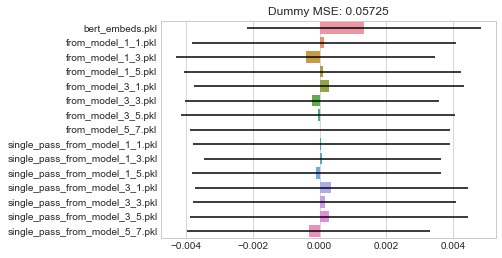

In [207]:
scores = np.array(scores)
sns.barplot(y=files, x=score_dummy-scores, orient='h', xerr=errors)
plt.title(f'Dummy MSE: {np.round(score_dummy, 5)}')